In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# ECE 720 Assignment Hands-on Project 3

In this assignment, we will explore how to quantitatively analyze an RNN model.

Before working on the assignment, it is highly recommended reading the paper: [DeepStellar: model-based quantitative analysis of stateful deep learning systems](https://dl.acm.org/doi/10.1145/3338906.3338954) . Our materials will be highly relevant to this paper.

## Content:

1. Implement state abstraction---a key component in DeepStellar. (7pt)

   1.1 Build state abstraction and transition model based on training data. (4pt)
   
   1.2 Based on your implementation, which state is most frequently visited? (3pt)
   
2. Implement a function to obtain the corresponding trace* (state transition) in the abstracted model of a given text. (4pt)

3. Implement the metrics for measuring **state-based trace similarity** and **transition-based trace similarity**. (4pt, 2pt for each metric)

4. Use DeepStellar to analyze adversarial attack (4pt)

    4.1 Output traces of original data and attacked data. (1pt)
    
    4.2 Draw a figure to visualize each trace. (1pt)
    
    4.3 Calculate their **state-based trace similarity** and **transition-based trace similarity** based on the defined functions in 3. (1pt)
    
    4.4 Analyze the difference between original data and attacked data: give a brief explanation on why the model's prediction result is incorrect on the attacked data. (1pt)
    
5. Brief discussion on the open question: how to further improve the state abstraction method? (1pt)

**trace: a sequence of RNN state vectors*

## Background

In this assignment, let's consider the following task: **multi-class text classification**.

The data used is AGNews dataset [\[1\]](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html),[\[2\]](https://pytorch.org/text/stable/datasets.html#ag-news). In this dataset, each news corpus is labeled as one of four classes:

- 0-World
- 1-Sports
- 2-Business
- 3-Sci/Tech

Then, let's consider using this RNN model, specifically, a simple one-layer GRU model, the hidden-state size is 256.

![RNN model](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg3/rnn-many-to-one-ltr.png)

In this RNN model, we used a word-based tokenizer to tokenize a sentence and the vocab was built with top-30000 frequent words in the training data. The embedding layer has a size of 200. The final hidden states will go into two linear layers to generate the classification result. Since this is a multi-class classification problem, we utilize the `nn.CrossEntropyLoss` for training.

We have done the training for you, therefore you will have a pre-trained RNN model for this assigment. The training accuracy is around 91.5%.

The detailed model architecture is listed as below:

```
SimpleGRUMultiClassification(
  (embedding): Embedding(30002, 200)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): GRU(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (softmax): Softmax(dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)
```

Now let's try to load the pretrained model!

In [ ]:
! wget --no-check-certificate "https://onedrive.live.com/download?cid=9F719B6A4F197D9C&resid=9F719B6A4F197D9C%214304&authkey=ABp_zbZfV0lDbBI" -O asg3.zip
! unzip asg3.zip

# install some libraries if you're working with your own PC.
# pip install -r requirements.txt

In [2]:
import imp
import platform

py_version = platform.python_version().split('.')[1]
if py_version == '7':
    util = imp.load_compiled("util", "./util.cpython-37.pyc")
elif py_version == '8':
    util = imp.load_compiled("util", "./util.cpython-38.pyc")
elif py_version == '9':
    util = imp.load_compiled("util", "./util.cpython-39.pyc")
else:
    raise NotImplementedError('Only supports Python>=3.7')

/home/jupyter-amirhossein/projects/MLSE/Assignment3/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import joblib
import torch
import numpy as np

from util import load_tokenizer, SimpleGRUMultiClassification

In [4]:
# load pre-trained model and tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('./file/agnews_ckpt_best.pth', map_location=device)
model = SimpleGRUMultiClassification(*ckpt['model_args'])
model = model.to(device)
model.eval()
model.load_state_dict(ckpt['model'])

_, tokenizer, _, _ = load_tokenizer('./file/tokenizer.pt')

Here we provide a simple example on how to use this pretrained model to predict a new corpus. We use the `model.proifle` function to get both the hidden states and the prediction results on each hidden state. The result from final hidden state is used as the model's prediction result.

In [5]:
example_text = "Yahoo introducing new search engine tools\",\"Internet giant Yahoo is introducing new search engine tools that will enable users to create personal folders and share their favorite links with others."

label2text = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Convert the text corpus into tokens, and transform the token list into a torch tensor.
tokens = torch.tensor(tokenizer(example_text)).to(device).long()

# add a dimension to the tensor, to let it become a tensor with a size of (1, n), where 1 represent the batch size, and n is the number of tokens.
input_tensor = tokens.view(1, -1)

# use ``model.profile`` to predict on the input tensor.
hidden_states, pred_tensor = model.profile(input_tensor)

# recall that the output is a 4-dim array processed by softmax function, therefore we utilize the ``argmax`` function to get the prediction result.
pred = np.argmax(pred_tensor[0].cpu().detach().numpy()[-1])
print('The predicted label is: %s' % label2text[pred])

The predicted label is: Sci/Tech


Now, we can profile on the training data, to get all the hidden states and prediction results. Since this process is time-consuming, we've done it for you. Besides, in DeepStellar, the high-dimension hidden states also need to be processed by PCA to get low-dimension ones. We've also done the PCA process for you. And you can simply load the processed data and the pca model, which will be used in the remaining parts of this assignment. In this assignment, we take top-3 principal components in PCA.

In [6]:
# load pre-processed data and pca model

(pca_data, embedding, text, _, label, pred, pred_pro) = joblib.load('./file/pca_data.prt')
pca_model = joblib.load('./file/pca_model.pt')

### Data Structure
- `pca_data` is a list. Each element in this list is a numpy array of size `(n,3)`, representing the pca-processed hidden states of this training text corpus.
- `embedding` is a list. Each element in this list is a numpy array of size `(n,)`, representing the embeddings of this training text corpus.
- `text` is a list. Each element in this list is a numpy array of size `(n,)`, representing the tokenized words of this training text corpus.
- `label` is a list. Each element in this list is an integer, representing the ground-truth label of this training text corpus.
- `pred` is a list. Each element in this list is an integer, representing the prediction result of this training text corpus.
- `pred_pro` is a list. Each element in this list is a numpy array of size `(n,4)`, representing all the intermediate prediction probabilities of this training text corpus.

`pca_model` is a Python object of PCA, which is trained on the training data, and we provide the API reference about how to use this.

### API Reference (all relevant APIs included)

#### pca_model.do_reduction(data_list)

**Parameter:**
- **data_list** (list) - A list of numpy array where each array stores a sequence of hidden states

**Returns:**
- **pca_data** (list) - A list of numpy array where each array stores a sequence of concrete states processed by pca

#### Examples
```
>>> data_list = [np.random.random((200, 256))]
>>> pca_data = pca_model.do_reduction(data_list)
>>> pca_data[0].shape
'(200, 3)'
```
---

#### tokenizer(text)

**Parameter:**
- **text** (str) - A string of text corpus.

**Returns:**
- **tokens** (list) - A list of word tokens.

#### Examples
```
>>> tokens = tokenizer("hello world")
>>> tokens
'[12225, 47]'
```
---

#### model.profile(input_tensor)

**Parameter:**
- **input_tensor** (torch.Tensor) - The input tensor should be a torch Long tensor of shape `(B,N)`, `B`
is the batch size, and `N` is the number of tokens.

**Returns:**
- **hidden_states** (torch.Tensor) - The hidden states of shape `(B,N,H)`, `B` is the batch size, and `N` is
the number of tokens, `H` is the dimension of hidden states.
- **pred_tensor** (torch.Tensor) - The prediction result of shape `(B,N,C)`, `B` is the batch size, and `N` is
the number of tokens, `C` is the number of class (classification target).

#### Examples
```
>>> tokens = tokenizer("hello world")
>>> tokens
'[12225, 47]'
>>> hidden_states, pred_tensor = model.profile(torch.tensor(tokens).long().view(1, -1))
>>> hidden_states.size()
'torch.Size([1, 2, 256])'
>>> pred_tensor.size()
'torch.Size([1, 2, 4])'
```
---


You can spend some time on trying these functions and APIs. Once you feel good about using them, let's turn to the assignment quesions ;-)

## 1. Implement DeepStellar. (7pt)

### The following `class DeepStellar` is the basic class of DeepStellar model, you will need to finish the todo blocks in order to:

1. Build state transition model based on training data. (4pt)

2. Based on your implementation, which state is most frequently visited? (3pt)


In [7]:
class DeepStellar(object):
    r"""The class of DeepStellar model.
    Arguments
    ---------
    rnn : torch.nn.Module
        A PyTorch based RNN model that would be analyzed in DeepStellar.
    tokenizer : tokenizer_pipeline object
        The tokenizer used when training the RNN model. This is used to split
        text corpus and convert them into word-based tokens.
    pca_model : PCAReduction object
        The PCA model. This is to transform a high-dimension data into low-dimension
        one. Note that in this assignment, we keep top-3 dimension in PCA.
    pca_data : list
        This is a list of numpy array, which should be the pca-processed hidden states.
        The shape of each numpy array should be ``(n, 3)``, where n is the length of
        each sequence.
    m_split : int
        m_split decides how many intervals to be split on each dimension.
    Example
    -------
    >>> deep_stellar_model = DeepStellar(rnn, tokenizer, pca_model, pca_data, 10)
    >>> state_distribution = deep_stellar_model.get_state_distribution()
    """
    def __init__(self, rnn, tokenizer, pca_model, pca_data, m_split=10):
        self.rnn = rnn
        self.tokenizer = tokenizer
        self.pca = pca_model
        self.m_split = m_split
        self.pca_data = pca_data
        self.traces = self._build_abstraction_model()
        
    def _build_abstraction_model(self):
        """Iterate all the training data (``self.pca_data``) to build DeepStellar
        Returns
        -------
        traces : list
            A list of numpy array which should be the abstracted states. Each numpy
            array should look like
            ``[[1, 2, 3], [4, 5, 6], ...]``,
            and each element represents which interval it belongs to.
            For example, suppose the lower bound of first dimension is -10, the upper
            bound is 10, we split the grid into 10 intervals, then each interval
            has a size of 2. Hence, 4.67 should belong to the grid 7 because
            ``(4.67 - (-10)) / 2 = 7.335`` (We use 0 to denote the first interval
            therefore 10th interval will be 9)
        """

        '''
        Hint: you might want to first iterative through all arrays in
        ``self.pca_data`` to find the min value and max value of each PCA dimension.
        Then, you can calculate the size of each interval, and transform the concrete
        states in ``self.pca_data`` into abstracted states.
        
        And you might want to add some attributes to this class for future accessing 
        your state abstraction model.

        Your final output should be a list of state trace as addressed in the above
        comments.
        '''

        # ======= Below is assignment TODO ======= #
        import math

        NUM_DIMS = 3
        self.min_values = [np.inf] * NUM_DIMS
        self.max_values = [-np.inf] * NUM_DIMS
        self.interval_length = [0] * NUM_DIMS
        traces = []

        for text in pca_data:
            for hidden_state in text:
                for idx, hs in enumerate(hidden_state):
                    if hs > self.max_values[idx]:
                        self.max_values[idx] = hs
                    elif hs < self.min_values[idx]:
                        self.min_values[idx] = hs


        for i in range(NUM_DIMS):
            self.interval_length[i] = (self.max_values[i] - self.min_values[i])/self.m_split

        for text in pca_data:
            t = []
            for hidden_state in text:
                h = []
                for idx, hs in enumerate(hidden_state):
                    s = math.floor((hs-self.min_values[idx])/self.interval_length[idx])
                    if s == self.m_split:  s = self.m_split-1
                    h.append(s)
                t.append(h)
            traces.append(np.array(t))
        # ======= Above is assignment TODO ======= #

        return traces

    def get_state_distribution(self):
        """Iterate all the traces to calculate the state distribution.
        Returns
        -------
        states : numpy.array()
            A numpy array which has a size of ``(m_split, m_split, m_split)``, and the
            value of represents the visit time of this abstract state.
        """
        states = np.zeros((self.m_split, self.m_split, self.m_split))
        for trace in self.traces:
            for state in trace:
                states[state[0], state[1], state[2]] += 1
        return states

Now let's build the DeepStellar model. Note that `m_split` will be set as **10** in this assignment.

In [8]:
deep_stellar = DeepStellar(model, tokenizer, pca_model, pca_data, 10)
states = deep_stellar.get_state_distribution()

Then, you can try to find the most frequently visited state by iterate through `states`. Please write your code
in the following cell and paste your results in the project report.

In [9]:
# ======= Below is assignment TODO ======= #
most_visited = None
max_visits = 0
m_split = len(states)

for state_0 in range(m_split):
    for state_1 in range(m_split):
        for state_2 in range(m_split):
            if states[state_0, state_1, state_2] > max_visits:
                max_visits = states[state_0, state_1, state_2]
                most_visited = [state_0, state_1, state_2]

print(f'Most frequently visited state is {most_visited} which is visited {int(max_visits)} times')
# ======= Above is assignment TODO ======= #

Most frequently visited state is [5, 4, 5] which is visited 380580 times


## 2. Implement a function to obtain trace of a given text. (4pt)

Since we have build the DeepStellar model, now we'd like to think about how to extract trace on a new text corpus.

You will need to finish the following function, and please following the comments on the returns types. :-)

In [10]:
def get_trace(deep_stellar, text):
    """Get the state trace of a new text corpus.
    Arguments
    ---------
    deep_stellar : DeepStellar object
    text : str
    Returns
    -------
    trace : numpy.array()
        A numpy array to store the state trace, and this numpy array should look like
        ``[[1, 2, 3], [4, 5, 6], ...]``,
        and each element represents which interval it belongs to.
        If the value is smaller than the lower bound, then we denote it as -1, if it's
        larger than the higher bound, then we denote it as 10 (recall that we denote 10
        intervals from 0 to 9).
    pred : int
        The prediction result of this text.
    """

    # ======= Below is assignment TODO ======= #
    import math

    tokens = torch.tensor(tokenizer(text)).to(device).long()
    input_tensor = tokens.view(1, -1)
    hidden_states, pred_tensor = model.profile(input_tensor)
    pca_data = pca_model.do_reduction([torch.squeeze(hidden_states).cpu().detach().numpy()])[0]
    trace = []

    for hidden_state in pca_data:
        h = []
        for idx, hs in enumerate(hidden_state):
            s = math.floor((hs-deep_stellar.min_values[idx])/deep_stellar.interval_length[idx])
            if s == deep_stellar.m_split:  s = deep_stellar.m_split-1
            elif s > deep_stellar.m_split:  s = deep_stellar.m_split
            elif s < 0:  s = -1
            h.append(s)
        trace.append(h)

    trace = np.array(trace)
    pred = np.argmax(pred_tensor[0].cpu().detach().numpy()[-1])
    # ======= Above is assignment TODO ======= #

    return trace, pred

Now let's test this function using a minimal example.

In [11]:
trace, pred = get_trace(deep_stellar, "hello world")

## 3. Implement **state-based trace similarity** and **transition-based trace similarity**. (4pt)

In [12]:
def state_based_trace_similarity(tr1, tr2):
    """Calculate the state-based trace similarity
    Arguments
    ---------
    tr1 : numpy.array()
        A numpy array to store the state trace, and this numpy array should look like
        ``[[1, 2, 3], [4, 5, 6], ...]``
    tr2 : numpy.array()
        A numpy array to store the state trace, and this numpy array should look like
        ``[[1, 2, 3], [4, 5, 6], ...]``
    Returns
    -------
    similarity : float
    """
    # ======= Below is assignment TODO ======= #
    s1 = {str(i) for i in tr1}
    s2 = {str(i) for i in tr2}

    return len(s1.intersection(s2))/len(s1.union(s2))
    # ======= Above is assignment TODO ======= #

In [13]:
def transition_based_trace_similarity(tr1, tr2):
    """Calculate the transition-based trace similarity
    Arguments
    ---------
    tr1 : numpy.array()
        A numpy array to store the state trace, and this numpy array should look like
        ``[[1, 2, 3], [4, 5, 6], ...]``
    tr2 : numpy.array()
        A numpy array to store the state trace, and this numpy array should look like
        ``[[1, 2, 3], [4, 5, 6], ...]``
    Returns
    -------
    similarity : float
    """
    # ======= Below is assignment TODO ======= #
    s1 = {str((list(tr1[i]), list(tr1[i+1]))) for i in range(len(tr1)-1)}
    s2 = {str((list(tr2[i]), list(tr2[i+1]))) for i in range(len(tr2)-1)}

    return len(s1.intersection(s2))/len(s1.union(s2))
    # ======= Above is assignment TODO ======= #

## 4. Use DeepStellar to analyze adversarial attack (4pt)

Now consider the following two paragraphs of text.

> House defeats FDA proposal, House lawmakers yesterday killed a Senate proposal to give the Food and Drug Administration authority over the manufacture and marketing of tobacco.

> House kills FDA proposal, House lawmakers yesterday killed a Senate proposal to give the Food and Drug Administration authority over the manufacture and marketing of tobacco.

Let's first see their prediction results. Try to use `get_trace(deep_stellar, text)` to print their traces and prediction results.

In [15]:
text1 = "House defeats FDA proposal, House lawmakers yesterday killed a Senate proposal to give the Food and Drug Administration authority over the manufacture and marketing of tobacco."
text2 = "House kills FDA proposal, House lawmakers yesterday killed a Senate proposal to give the Food and Drug Administration authority over the manufacture and marketing of tobacco."

In [16]:
# ======= Below is assignment TODO ======= #
tr1, pred1 = get_trace(deep_stellar, text1)
tr2, pred2 = get_trace(deep_stellar, text2)

print("trace of text1:")
print(tr1)
print("prediction result for text1:")
print(pred1)

print("trace of text2:")
print(tr2)
print("prediction result for text2:")
print(pred2)
# ======= Above is assignment TODO ======= #

trace of text1:
[[5 4 5]
 [5 5 5]
 [5 5 5]
 [4 5 5]
 [4 5 5]
 [4 5 6]
 [4 5 6]
 [4 5 6]
 [5 5 6]
 [5 5 6]
 [5 5 6]
 [5 5 6]
 [5 5 6]
 [5 6 6]
 [5 6 6]
 [5 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]
 [4 6 6]]
prediction result for text1:
2
trace of text2:
[[5 4 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 6 5]
 [5 6 6]
 [5 6 6]
 [5 6 5]
 [5 6 5]
 [5 6 5]
 [5 6 5]
 [5 6 5]
 [5 6 6]
 [5 6 6]
 [5 7 6]
 [5 7 6]
 [5 7 6]
 [5 7 6]
 [5 7 6]
 [5 7 6]
 [4 7 6]]
prediction result for text2:
0


Now, try to use some graphic lib to plot these two traces. You might want to take a look on this (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html).

In [19]:
tr1

array([[5, 4, 5],
       [5, 5, 5],
       [5, 5, 5],
       [4, 5, 5],
       [4, 5, 5],
       [4, 5, 6],
       [4, 5, 6],
       [4, 5, 6],
       [5, 5, 6],
       [5, 5, 6],
       [5, 5, 6],
       [5, 5, 6],
       [5, 5, 6],
       [5, 6, 6],
       [5, 6, 6],
       [5, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6],
       [4, 6, 6]])

In [20]:
tr1[:,0]

array([5, 5, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

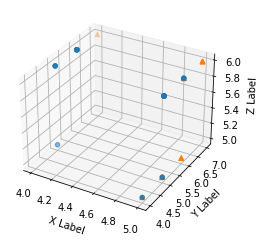

In [23]:
import matplotlib.pyplot as plt

# ======= Below is assignment TODO ======= #
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for m, trace in [('o', tr1), ('^', tr2)]:
    xs = trace[:,0]
    ys = trace[:,1]
    zs = trace[:,2]
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# ======= Above is assignment TODO ======= #

What is the state-based trace similarity and transition-based trace similarity of them?

In [24]:
print('State-based trace similarity: %.2f' % state_based_trace_similarity(tr1, tr2))
print('Transition-based trace similarity: %.2f' % transition_based_trace_similarity(tr1, tr2))

State-based trace similarity: 0.30
Transition-based trace similarity: 0.16


## Remark

At this point (after finishing these three assignments), you should be ready with basis of machine learning testing techniques!;-) Now you can go further to explore and contribute to this research area!